In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from pycirclize import Circos
import pandas as pd
from scipy.signal import hilbert, coherence, welch
from scipy import signal

In [2]:

##############################################################
#Filter the signal
def filtersignal(s,f):

    # Define bandpass filter parameters
    fs = 128  # Sampling frequency
    lowcut = f[0]  # Lower cutoff frequency (Hz)
    highcut = f[1]  # Upper cutoff frequency (Hz)
    order = 4  # Filter order

    # Design a bandpass Butterworth filter
    b, a = signal.butter(order, [lowcut/(fs/2), highcut/(fs/2)], btype='band')

    return signal.filtfilt(b, a, s)

##############################################################
#Phase Lag Index
def phase_lag_index(signal1, signal2):
    pli =  []
    freq_bands = [(4,8),(8,12),(12,24),(24,35),(35,45)]
    for f in freq_bands:
        signal1 = filtersignal(signal1,f)
        signal2 = filtersignal(signal2,f)
        # Calculate the analytic signals
        analytic_signal1 = hilbert(signal1)
        analytic_signal2 = hilbert(signal2)
        
        # Compute the phases
        phase1 = np.angle(analytic_signal1)
        phase2 = np.angle(analytic_signal2)
        
        # Calculate the phase differences
        phase_diff = phase1 - phase2
        
        # Compute the Phase Lag Index (PLI)
        pli.append(np.abs(np.mean(np.sign(phase_diff))))
    
    return pli

##################################################################
#Phase Locking Value
def phase_locking_value(signal1, signal2):
    plv =  []
    freq_bands = [(4,8),(8,12),(12,24),(24,35),(35,45)]
    for f in freq_bands:
        signal1 = filtersignal(signal1,f)
        signal2 = filtersignal(signal2,f)
    # Calculate the analytic signals
        analytic_signal1 = hilbert(signal1)
        analytic_signal2 = hilbert(signal2)
        
        # Compute the phases
        phase1 = np.angle(analytic_signal1)
        phase2 = np.angle(analytic_signal2)
        
        # Calculate the phase differences
        phase_diff = np.exp(1j * (phase1 - phase2))
        
        # Compute the Phase Locking Value (PLV)
        plv.append(np.abs(np.mean(phase_diff)))
    
    return plv

###################################################################
#Coherence
def coherence_signals(x, y):
    freqs, Cxy = coherence(x, y, fs=128, noverlap= 64,window='hann',nperseg=128)
    Cxy_t = np.mean(Cxy[np.logical_and(freqs >= 4, freqs < 8)])
    Cxy_a = np.mean(Cxy[np.logical_and(freqs >= 8, freqs < 12)])
    Cxy_bl = np.mean(Cxy[np.logical_and(freqs >= 12, freqs < 24)])
    Cxy_bh = np.mean(Cxy[np.logical_and(freqs >= 24, freqs < 35)])
    Cxy_g = np.mean(Cxy[np.logical_and(freqs >= 35, freqs < 45)])
    Cxy_f = [Cxy_t, Cxy_a, Cxy_bl, Cxy_bh, Cxy_g]
    return Cxy_f

#######################################################################
#PSD
def power_spectral_density(x):
    freqs,Pxx = welch(x, fs=128, noverlap= 64, window='hann',nperseg=128)
    Cxy_t = np.mean(Pxx[np.logical_and(freqs >= 4, freqs < 8)])/np.max(Pxx[np.logical_and(freqs >= 4, freqs < 8)])
    Cxy_a = np.mean(Pxx[np.logical_and(freqs >= 8, freqs < 12)])/np.max(Pxx[np.logical_and(freqs >= 8, freqs < 12)])
    Cxy_bl = np.mean(Pxx[np.logical_and(freqs >= 12, freqs < 24)])/np.max(Pxx[np.logical_and(freqs >= 12, freqs < 24)])
    Cxy_bh = np.mean(Pxx[np.logical_and(freqs >= 24, freqs < 35)])/np.max(Pxx[np.logical_and(freqs >= 24, freqs < 35)])
    Cxy_g = np.mean(Pxx[np.logical_and(freqs >= 35, freqs < 45)])/np.max(Pxx[np.logical_and(freqs >= 35, freqs < 45)])
    Cxy_f = [Cxy_t, Cxy_a, Cxy_bl, Cxy_bh, Cxy_g]
    return Cxy_f

# Topoplots for PSD

In [3]:
import mne

In [118]:
#create a raw object
ch_names = ['Fp1',
'AF3',
'F3',
'F7',
'FC5',
'FC1',
'C3',
'T7',
'CP5',
'CP1',
'P3',
'P7',
'PO3',
'O1',
'Oz',
'Pz',
'Fp2',
'AF4',
'Fz',
'F4',
'F8',
'FC6',
'FC2',
'Cz',
'C4',
'T8',
'CP6',
'CP2',
'P4',
'P8',
'PO4',
'O2',]

s_freq = 128

info = mne.create_info(ch_names, s_freq, ch_types='eeg')

montage = mne.channels.make_standard_montage('biosemi32')

info.set_montage(montage)

data = sio.loadmat('/home/desktop/Desktop/22104412_Docs/EEG-COGMusic/Baseline/datasets/s01_datasets_Zscore_clipped.mat')

In [119]:
psd_total = data['psd']
labels_skf = data['labels_kfold']

In [120]:
psd_total.shape

(40, 75, 32, 5)

In [121]:
l_skf = np.zeros([40,1])
l_skf[np.where(labels_skf[:,1]>5)[0]] = 1

li = np.where(l_skf == 0)[0]
hi = np.where(l_skf == 1)[0]

In [122]:
psd_total.shape, li.shape, hi.shape

((40, 75, 32, 5), (16,), (24,))

In [123]:
psd_l = psd_total[li]
psd_h = psd_total[hi]

In [124]:
psd_l = np.mean(psd_l,0)
psd_h = np.mean(psd_h,0)
psd_l.shape,psd_h.shape

((75, 32, 5), (75, 32, 5))

In [125]:
psd_l = np.mean(psd_l,0)
psd_h = np.mean(psd_h,0)

In [126]:
psd_l.shape,psd_h.shape

((32, 5), (32, 5))

(<matplotlib.image.AxesImage at 0x7d649bd17290>,
 <matplotlib.contour.QuadContourSet at 0x7d64a3397090>)

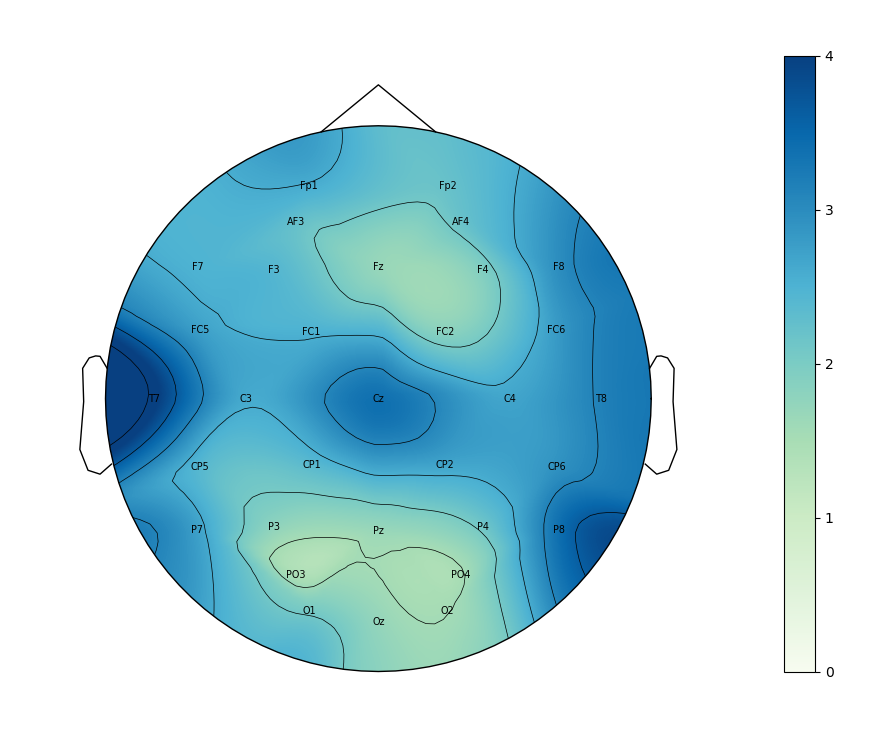

In [127]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from mne.viz import plot_topomap
cmap = 'GnBu'
fig, axs = plt.subplots(figsize=(20, 8), nrows = 1, ncols=1)
norm = mcolors.Normalize(vmin=0, vmax=4)
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='vertical')

# Set color bar label and ticks
cb.set_ticks(np.linspace(0, 4, 5))

plot_topomap(psd_l[:,3], info, axes=axs, sensors=True,names=ch_names, cmap='GnBu',show = False)

In [128]:
psd = psd_h-psd_l

(32, 5)


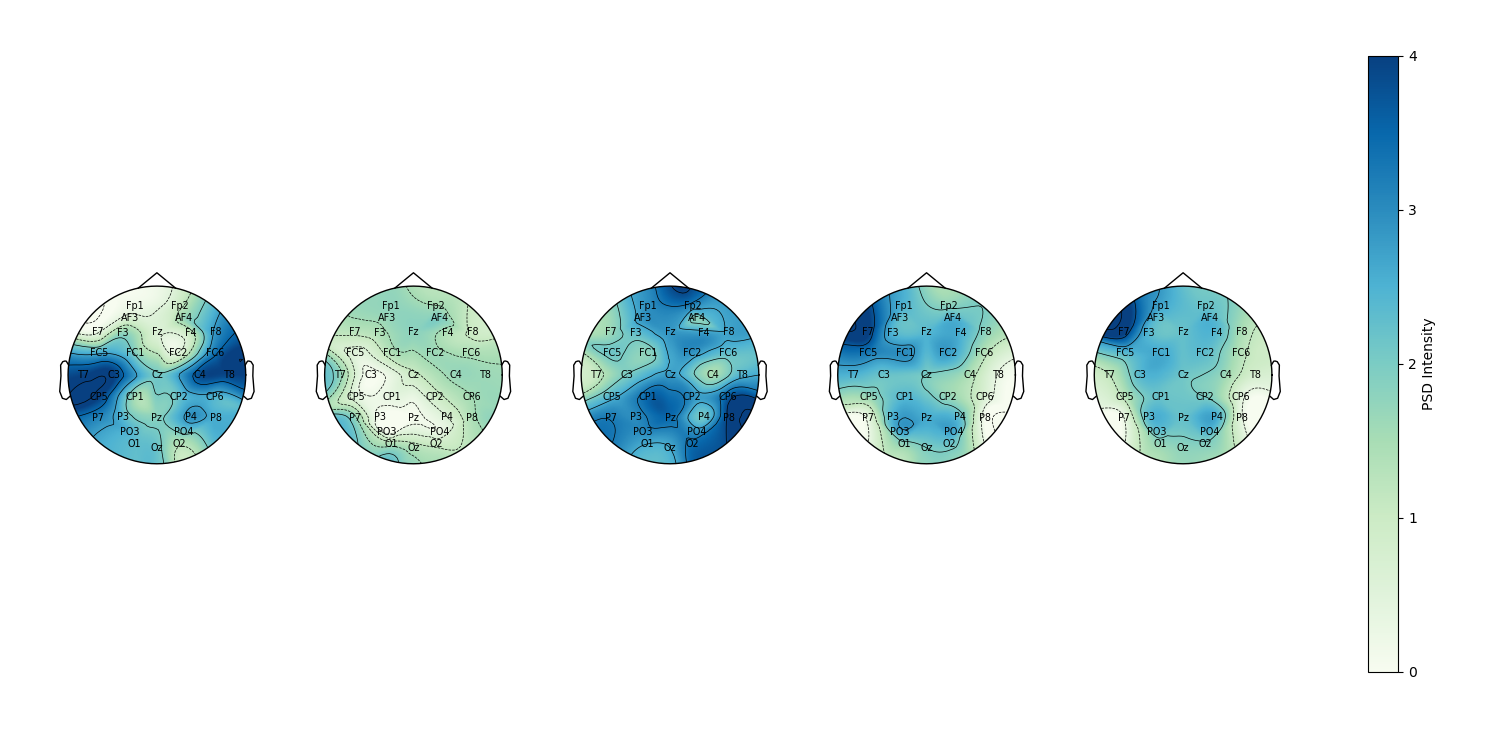

In [129]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from mne.viz import plot_topomap
cmap = 'GnBu'
# Create a figure and axes
fig, axs = plt.subplots(figsize=(20, 8), nrows = 1, ncols = 5)

# Define the color bar with the custom colormap
norm = mcolors.Normalize(vmin=0, vmax=4)
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='vertical')

# Set color bar label and ticks
cb.set_label('PSD Intensity')
cb.set_ticks(np.linspace(0, 4, 5))
index = 0
print(psd.shape)
for i in range(1):
    for j in range(5):
        plot_topomap(psd[:,index], info, axes=axs[j], sensors=True,names=ch_names, cmap='GnBu',show = False)
        index +=1

plt.savefig('S01_psd_diff_arousal.png')

In [140]:
data = sio.loadmat('/home/desktop/Desktop/22104412_Docs/EEG-COGMusic/Baseline/datasets/s01_datasets_Zscore_clipped.mat')
x_c=data['coh']
x_p = data['pli']
x_d = data['psd']
labels_skf = data['labels_kfold']

l_skf = np.zeros([40,1])
l_skf[np.where(labels_skf[:,0]>5)[0]] = 1


li = np.where(l_skf == 0)[0]
hi = np.where(l_skf == 1)[0]

x_n = np.zeros((40,75,32,32,5))
for trial in range(x_n.shape[0]):
    for sample in range(x_n.shape[1]):
        x_n[trial,sample,:,:,0] = x_c[trial,sample,:,:,0]+np.transpose(x_p[trial,sample,:,:,0])
        x_n[trial,sample,:,:,1] = x_c[trial,sample,:,:,1]+np.transpose(x_p[trial,sample,:,:,1])
        x_n[trial,sample,:,:,2] = x_c[trial,sample,:,:,2]+np.transpose(x_p[trial,sample,:,:,2])
        x_n[trial,sample,:,:,3] = x_c[trial,sample,:,:,3]+np.transpose(x_p[trial,sample,:,:,3])
        x_n[trial,sample,:,:,4] = x_c[trial,sample,:,:,4]+np.transpose(x_p[trial,sample,:,:,4])
    print(f'Completed trial {trial}')

for trial in range(x_n.shape[0]):
    for sample in range(x_n.shape[1]):
        for i in range(32):
            x_n[trial,sample,i,i,:] = x_d[trial,sample,i,:]
    print(f'Completed trial {trial}')

Completed trial 0
Completed trial 1
Completed trial 2
Completed trial 3
Completed trial 4
Completed trial 5
Completed trial 6
Completed trial 7
Completed trial 8
Completed trial 9
Completed trial 10
Completed trial 11
Completed trial 12
Completed trial 13
Completed trial 14
Completed trial 15
Completed trial 16
Completed trial 17
Completed trial 18
Completed trial 19
Completed trial 20
Completed trial 21
Completed trial 22
Completed trial 23
Completed trial 24
Completed trial 25
Completed trial 26
Completed trial 27
Completed trial 28
Completed trial 29
Completed trial 30
Completed trial 31
Completed trial 32
Completed trial 33
Completed trial 34
Completed trial 35
Completed trial 36
Completed trial 37
Completed trial 38
Completed trial 39
Completed trial 0
Completed trial 1
Completed trial 2
Completed trial 3
Completed trial 4
Completed trial 5
Completed trial 6
Completed trial 7
Completed trial 8
Completed trial 9
Completed trial 10
Completed trial 11
Completed trial 12
Completed tri

In [141]:
x_data = np.mean(x_n,1)

In [142]:
x_data.shape

(40, 32, 32, 5)

In [154]:
data_l = x_data[li]
data_h = x_data[hi]

In [155]:
data_l.shape, data_h.shape

((21, 32, 32, 5), (19, 32, 32, 5))

In [151]:
data_l = np.mean(data_l,0)
data_h = np.mean(data_h,0)

In [156]:
data_l_1 = data_l[0]
data_h_1 = data_h[0]
data_l_1.shape, data_h_1.shape

((32, 32, 5), (32, 32, 5))

In [152]:
data_l.shape

(32, 32, 5)

In [157]:
data = np.concatenate((data_l_1,data_h_1),2)
data.shape

(32, 32, 10)

In [16]:
import math

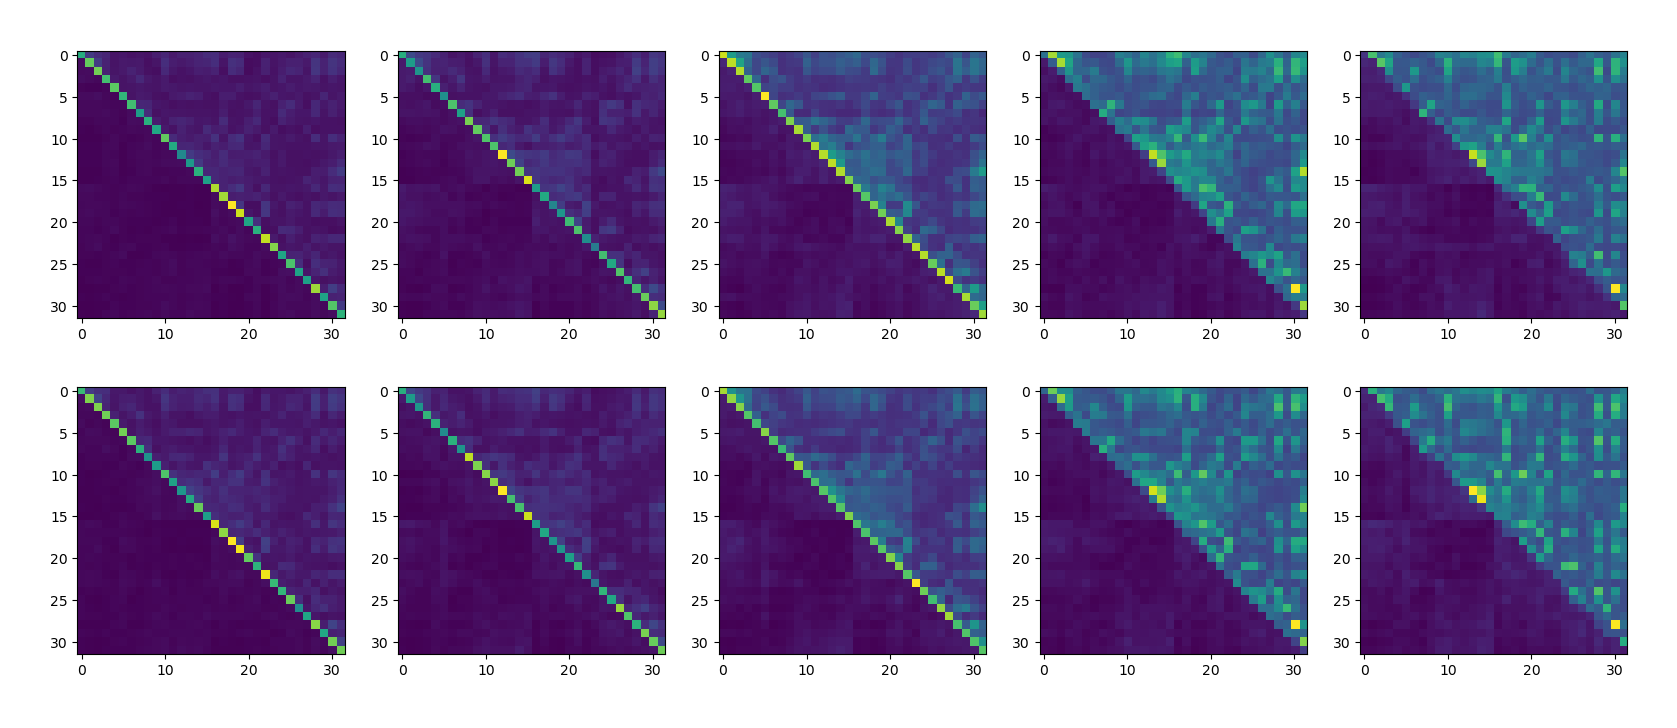

In [159]:
fig, axs = plt.subplots(figsize=(20, 8), nrows = 2, ncols = 5)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(data[:,:,i])

plt.savefig('S01_trial_lv_hv.png')

In [56]:
data_h.shape

(32, 32, 5)

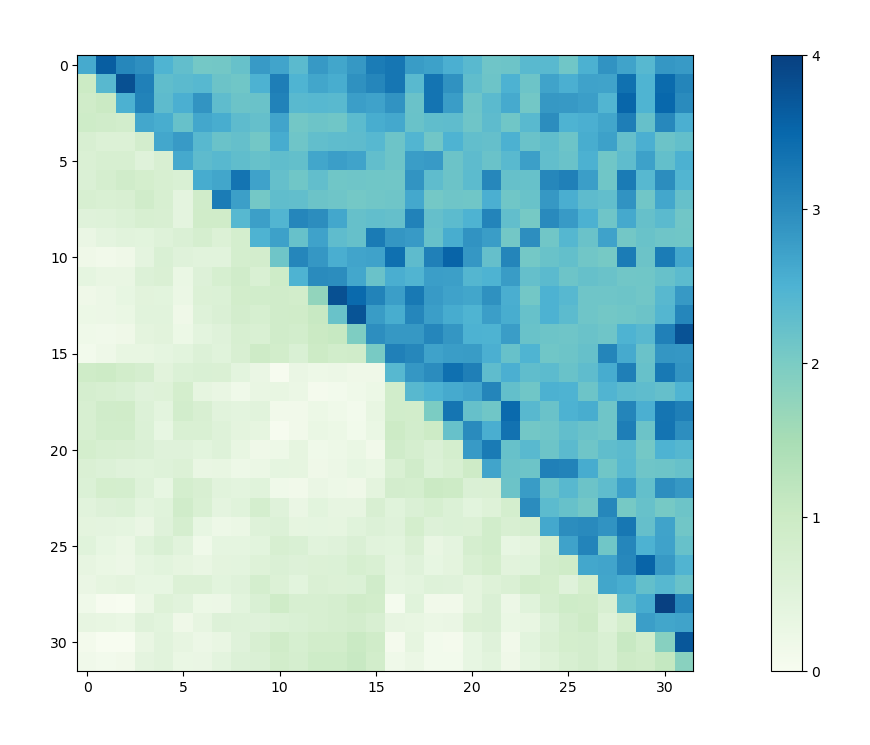

In [24]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from mne.viz import plot_topomap
cmap = 'GnBu'
fig, axs = plt.subplots(figsize=(20, 8), nrows = 1, ncols=1)
norm = mcolors.Normalize(vmin=0, vmax=4)
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='vertical')

# Set color bar label and ticks
cb.set_ticks(np.linspace(0, 4, 5))
axs.imshow(np.log10(data_l[:,:,3]), cmap = cmap)

In [39]:
x_data.shape

(40, 32, 32, 5)

In [40]:
x_data = x_data.reshape(40,-1)
x_data.shape

(40, 5120)

In [8]:
from sklearn.manifold import MDS

In [18]:
data = sio.loadmat('/home/desktop/Desktop/22104412_Docs/EEG-COGMusic/Baseline/datasets/s07_datasets_Zscore_clipped.mat')
x_c=data['coh']
x_p = data['pli']
x_d = data['psd']
labels_skf = data['labels_kfold']

l_skf = np.zeros([40,1])
l_skf[np.where(labels_skf[:,0]>5)[0]] = 1


li = np.where(l_skf == 0)[0]
hi = np.where(l_skf == 1)[0]

x_n = np.zeros((40,75,32,32,5))
for trial in range(x_n.shape[0]):
    for sample in range(x_n.shape[1]):
        x_n[trial,sample,:,:,0] = x_c[trial,sample,:,:,0]+np.transpose(x_p[trial,sample,:,:,0])
        x_n[trial,sample,:,:,1] = x_c[trial,sample,:,:,1]+np.transpose(x_p[trial,sample,:,:,1])
        x_n[trial,sample,:,:,2] = x_c[trial,sample,:,:,2]+np.transpose(x_p[trial,sample,:,:,2])
        x_n[trial,sample,:,:,3] = x_c[trial,sample,:,:,3]+np.transpose(x_p[trial,sample,:,:,3])
        x_n[trial,sample,:,:,4] = x_c[trial,sample,:,:,4]+np.transpose(x_p[trial,sample,:,:,4])

for trial in range(x_n.shape[0]):
    for sample in range(x_n.shape[1]):
        for i in range(32):
            x_n[trial,sample,i,i,:] = x_d[trial,sample,i,:]

In [19]:
x_data = np.mean(x_n,1)
x_data = x_data.reshape(40,-1)
x_data.shape

(40, 5120)

In [20]:
embedding = MDS(n_components=2, normalized_stress='auto')

In [21]:
X_transformed = embedding.fit_transform(x_data)

In [22]:
X_transformed.shape

(40, 2)

In [23]:
sizes = [40]*40
sizes = np.array(sizes)

In [24]:
sizes_l = sizes[li]
sizes_h = sizes[hi]
sizes.shape

(40,)

In [25]:
Cl = np.mean(X_transformed[li],0)
Ch = np.mean(X_transformed[hi],0)

Euclidean distance between the points: 2.278161896971523


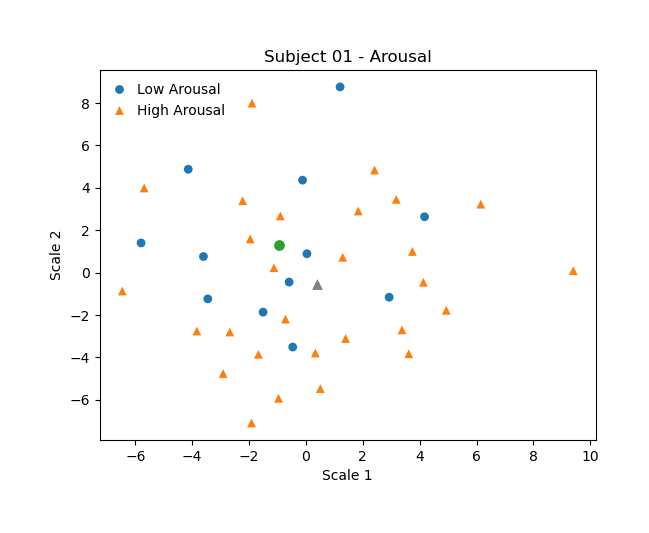

In [26]:
plt.scatter(X_transformed[li,0],X_transformed[li,1],marker = 'o',sizes = sizes_l)
plt.scatter(X_transformed[hi,0],X_transformed[hi,1], marker = '^',sizes = sizes_h)
plt.scatter(Cl[0],Cl[1], marker = 'o', sizes = [60], c = '#2ca02c',)
plt.scatter(Ch[0],Ch[1], marker = '^', sizes = [60], c = '#7f7f7f')
plt.xlabel('Scale 1')
plt.ylabel('Scale 2')
plt.legend(['Low Arousal','High Arousal'])
plt.title('Subject 01 - Arousal')
distance = np.linalg.norm(Cl - Ch)
print("Euclidean distance between the points:", distance)